In [99]:
import numpy as np
import pandas 
import matplotlib.pyplot as plt
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import math

In [105]:
def parse_folder(subfolder):
    args = subfolder.split("__")
    arg_dict = {}
    for arg in args:
        if("=" in arg):
            lk,v = arg.split("=")
            k = lk.split("/")[-1]
            arg_dict[k] = v
    return arg_dict

def check_query_dict(arg_dict, query_dict):
    for k, v in query_dict.items():
        if(arg_dict[k] != v):
            return False
    return True

def load_data(data_fn):
    subfolders = [ f.path for f in os.scandir(data_fn) if f.is_dir() ]
    sub_data_fn = os.path.join(data_fn, subfolders[0])
    files = [os.path.join(sub_data_fn, f) for f in os.listdir(sub_data_fn) if os.path.isfile(os.path.join(sub_data_fn, f))]
    event_acc = EventAccumulator(files[0])
    event_acc.Reload() 
    values = [c.value for c in event_acc.Scalars("rollout/ep_rew_mean")]
    return values
    
def get_stats(trajectories):
    traj_array = np.array(trajectories)
    traj_mean = np.mean(traj_array, axis=0)
    traj_sde = np.std(traj_array, axis=0)/math.sqrt(traj_array.shape[0])
    return traj_mean, traj_sde
    
def load_query(tf_logdir="/Users/aidancurtis/firehose/tmpdir", query_dicts = {}):
    subfolders = [ f.path for f in os.scandir(tf_logdir) if f.is_dir() ]
    arg_dicts = {subfolder: parse_folder(subfolder) for subfolder in subfolders}
    datas = {}
    for query_label, query_dict in query_dicts.items():
        data = []
        for folder_name, arg_dict in arg_dicts.items():
            if(check_query_dict(arg_dict, query_dict)):
                data.append(load_data(folder_name))
        # Clip all arrays to the minimum
        min_d = min([len(d) for d in data])
        datas[query_label] = get_stats([d[:min_d] for d in data])
    return datas

def plot_results(results):
    for (mean, sde) in results.values():
        plt.plot(mean)
        plt.fill_between(mean-sde, mean+sde)
    plt.legend(results.keys())

            

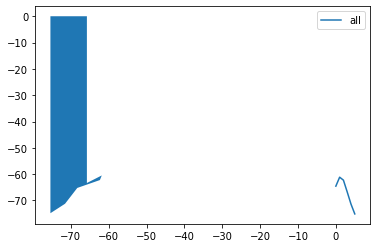

In [106]:
# Accumulate seeds and get mean/std
query_dicts = {"all": {}}
results = load_query(query_dicts=query_dicts)
plot_results(results)


In [83]:
# Plot